## Project 1.2 Count Objects
Given a set of images in which several subjects are captured against a relatively uniform, possibly noisy background, count the number of objects in each image. The objective is to define a processing pipeline that works for all images. You should explain the common processing pipeline and the results achieved. All images from a scene should be processed using the same parameter values, if applicable.

<h3>1. Read image and convert to Gray levels image</h3>

In [25]:
import cv2 
import numpy as np 
import math
import matplotlib.pyplot as plt     
import seaborn as sns 

Images = []
Result_Images = []
Gray_Images = []
for i in range(4):
      image = cv2.imread(f"./Images/1_2_{i+1}.png")
      Images.append(image)

for image in Images:
      image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      Gray_Images.append(image_gray)

<h3>2. Filter noise</h3>
<h4>a. Filter sinus noise using FFT (Fast Fourier transform)</h4>
"Loại bỏ cực đại địa phương, giữ lại cực đại trung tâm", "Tham số k tăng, mask lớn, thông tin giữ lại nhiều, bộ lọc thông thấp lọc ít tín hiệu nhiễu, ngược lại, k thấp lọc tốt hơn, nhưng mất mát ảnh hơn"

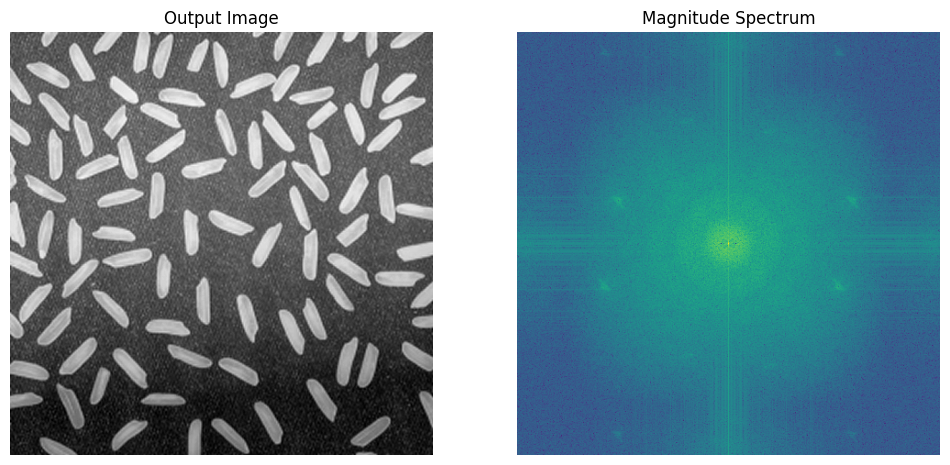

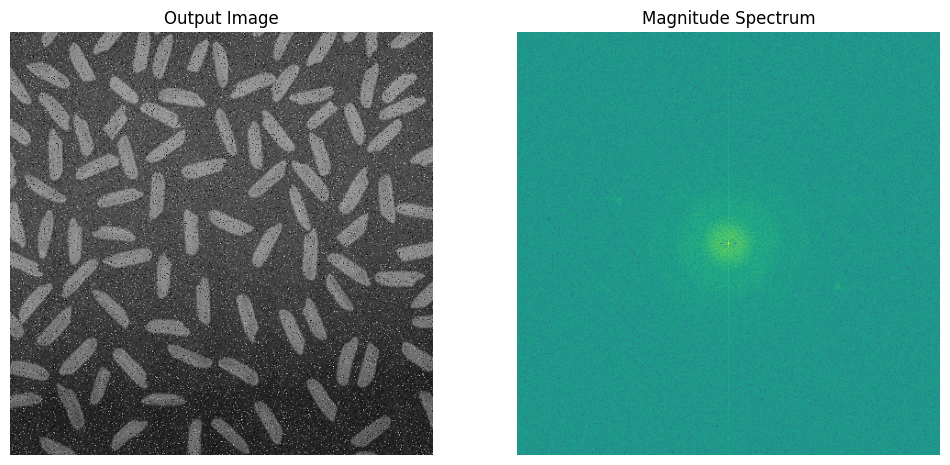

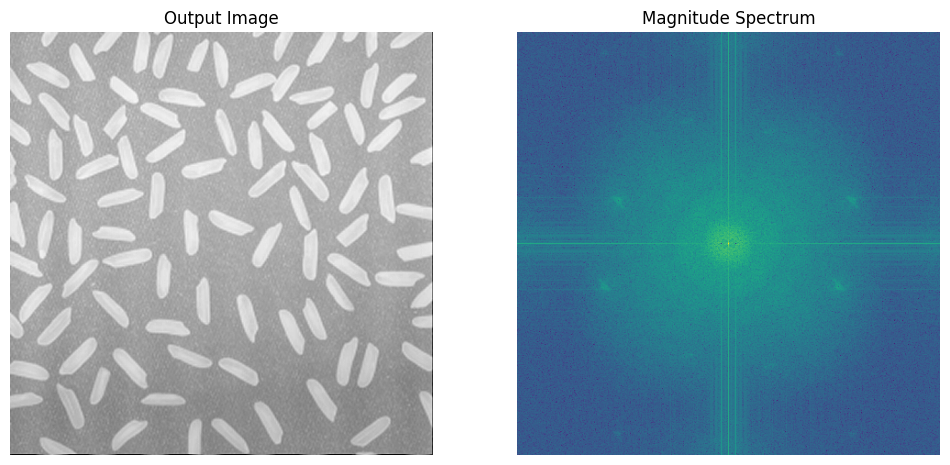

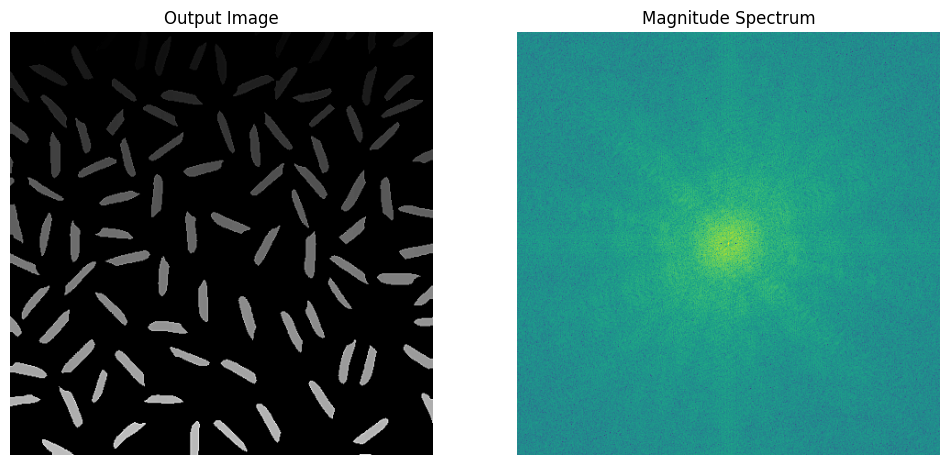

In [26]:
sinus_image_filtered = []
for img in Gray_Images:
    # Compute the Fourier transform
    dft = cv2.dft(np.float32(img), flags= cv2.DFT_COMPLEX_OUTPUT)      
    fshift = np.fft.fftshift(dft)  
    magnitude_spectrum = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1])+1) # Compute the magnitude spectrum (phổ biên độ)

    # # plot the image and its spectrum
    # fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # ax[0].imshow(img, cmap='gray'), ax[0].set_title('Input Image'), ax[0].axis('off')   
    # ax[1].imshow(magnitude_spectrum, cmap='viridis'), ax[1].set_title('Magnitude Spectrum'), ax[1].axis('off')
    # plt.show()

    # Set a cutoff frequency
    is_max = np.zeros_like(fshift, dtype=bool)
    crow, ccol = int(fshift.shape[0] / 2), int(fshift.shape[1] / 2)
    is_max[crow, ccol-8]=True  # Cực đại
    is_max[crow, ccol+8]=True  # Cực đại
    filtered_fshift = np.copy(fshift)
    filtered_fshift[is_max] = 0  # filtering

    # Compute the magnitude spectrum
    filtered_magnitude = 20 * np.log(cv2.magnitude(filtered_fshift[:, :, 0], filtered_fshift[:, :, 1])+1)
    # Compute the inverse Fourier transform
    dft_filtered = np.fft.ifftshift(filtered_fshift)
    img_back = cv2.idft(dft_filtered)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Apply Unsharp Mask to enhance details 
    lowpass = cv2.GaussianBlur(img_back, (5, 5), 0)  
    img_back = cv2.addWeighted(img_back, 0.6, lowpass, -0.2, 0)

    # plot the image and its spectrum
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_back, cmap='gray'), ax[0].set_title('Output Image'), ax[0].axis('off')   
    ax[1].imshow(filtered_magnitude, cmap='viridis'), ax[1].set_title('Magnitude Spectrum'), ax[1].axis('off')
    plt.show()

    sinus_image_filtered.append(img_back)

<h4>b. Filter noise salt, pepper</h4>

In [27]:
def show_img_hist(images):
    _, fg = plt.subplots(4, 2, figsize=(10, 10))
    for i, img in enumerate(images):
        sns.histplot(img.ravel(), color="k", ax=fg[i, 0])
        fg[i, 1].imshow(img, cmap="gray")
    plt.tight_layout()
    plt.show()

In [28]:
filtered_image = []
for img in sinus_image_filtered:
    image = cv2.medianBlur(img, 5)
    filtered_image.append(image)

<h4>c. Laplace filter to sharpe edge</h4>

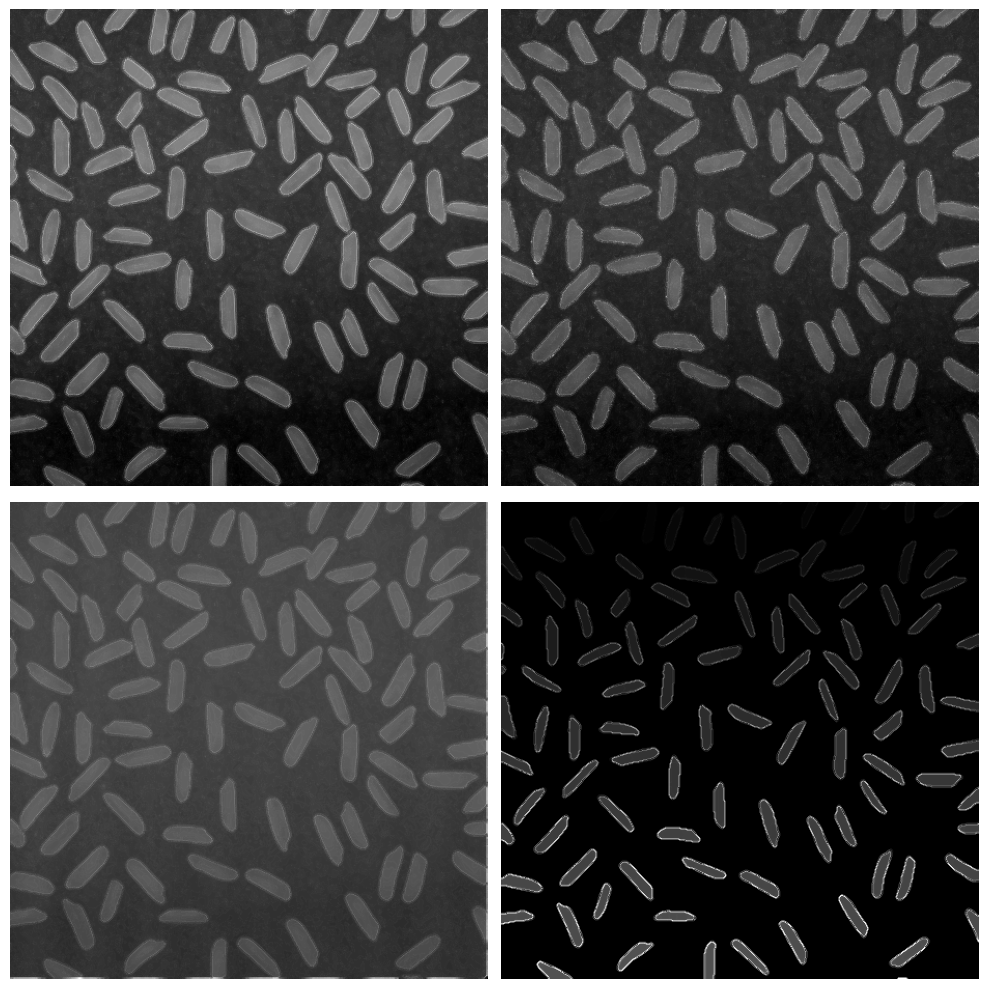

In [29]:
laplacian_image = []
_, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, img in enumerate(filtered_image):
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    enhanced_laplacian = cv2.addWeighted(img, 0.9, laplacian,1.2, 0)
    ax[i // 2, i % 2].imshow(enhanced_laplacian, cmap="gray"), ax[i // 2, i % 2].axis("off")
    laplacian_image.append(enhanced_laplacian)
plt.tight_layout()
plt.show()

<h3>3. Normalize, adjust Brightness, equalize histogram,... </h3>
a. Normalize the image: 0 -> 255, cv2.NORM_MINMAX (x - min) / (max - min)<br>
b. Increase Brightness by using gamma correction

In [30]:
normalized_image = []
for img in laplacian_image:
    normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    gamma = 0.25
    gamma_corrected = np.array(255*((img / 255) ** gamma), dtype = 'uint8')
    normalized_image.append(gamma_corrected)

<h3>4. Convert to Binary image (By using threshold function)</h3>

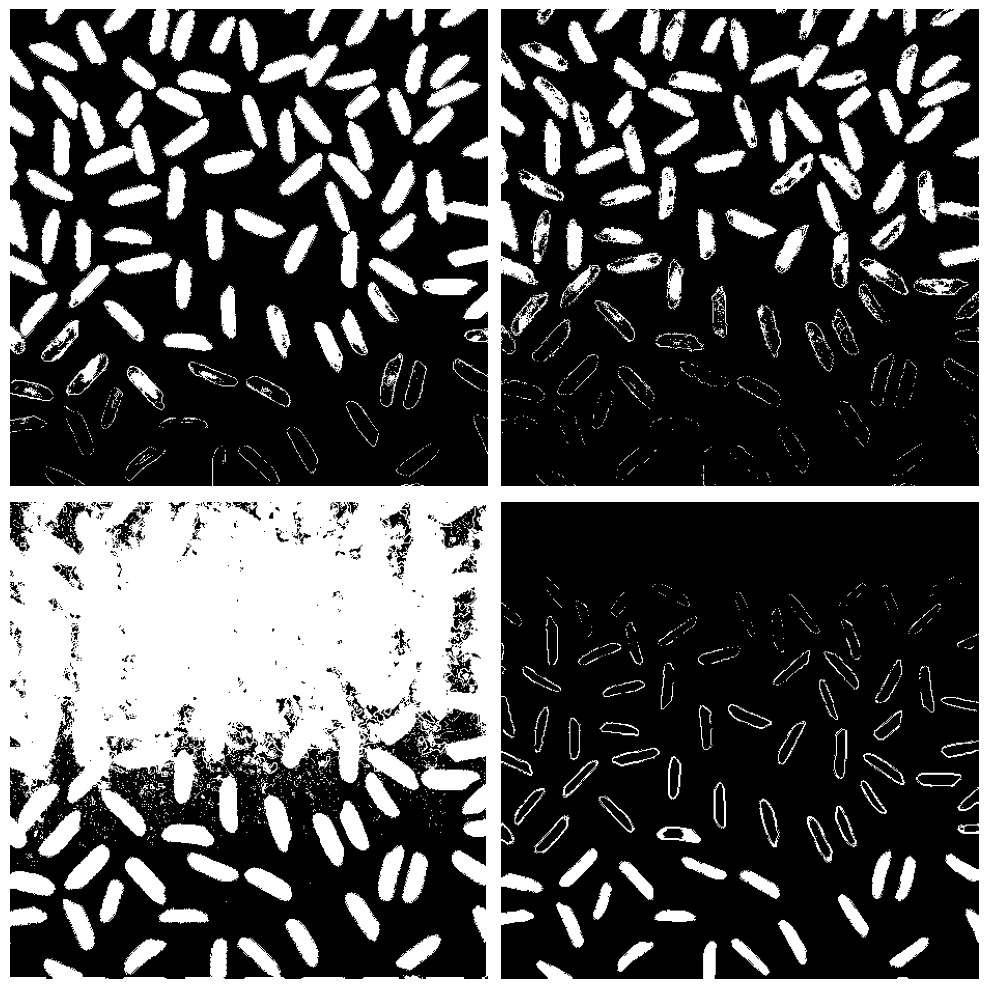

In [31]:
binary_image = []
_, ax = plt.subplots(2, 2, figsize=(10, 10))  
for i, img in enumerate(normalized_image):
    binary_img= cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)[1]
    ax[i // 2, i % 2].imshow(binary_img, cmap="gray"), ax[i // 2, i % 2].axis("off")
    binary_image.append(binary_img) 
plt.tight_layout()
plt.show()

<h3>5. Morphological operator on binary image (Opening, Closing)</h3>
Opening: Erision --> Dilation  (remove bridges, noise, small object, ..., but keep origin shape) <br>
Closing: Dilation --> Erision  (fill holes, keep origin shape) 

In [32]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))  
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))  

for img in binary_image:
    image = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel1)

    image = cv2.morphologyEx(image, cv2.MORPH_ERODE, kernel2)
